<a href="https://colab.research.google.com/github/rishichhabra29/Class-Conditioned-Attention-Enhanced-Seq2Seq-Sketch-Generator/blob/main/Class_Aware_Attention_Enhanced_RNN_for_Vector_Stroke_Sketch_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import itertools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

 <!-- {'num_layers': 3, 'init_stroke_weight': 0.3005040909723493, 'learning_rate': 0.00695201032803834}. Best is trial 2 with value: 0.9319656372070313. -->
<!-- Epoch 12, Train Loss: 14.4996, Validation Loss: 18.4055 -->

In [ ]:
epoch = 40
initial_stroke_weight=.2005040909723493
batch_size=64
class_emb_dim = 8
stroke_input_dim = 5
hidden_size = 64#128 #64#128#256
num_layers = 2
learning_rate = 0.0001952


# base_dir = "/content/drive/MyDrive/College-Work/temprary data store"
base_dir = "/content/drive/MyDrive/College-Work/dl-3_data"

model_saver_path = "/content/drive/MyDrive/College-Work/output"

image_saver_path = "/content/drive/MyDrive/College-Work/images"

# Maximum number of records to extract per file
max_records_per_file = 4000  # so total data will be max_records_per_file*number of classes


### Data Visualization

In [ ]:
def extract_limited_data_from_file(file_path, max_records):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return [
                [entry['word'], entry['drawing']]
                for entry in itertools.islice((json.loads(line) for line in f), max_records)
                if entry.get('recognized', False)  # Only include recognized drawings
            ]
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

# Load dataset
def load_dataset(base_dir, max_records_per_file=2000):
    all_data = []
    for filename in os.listdir(base_dir):
        file_path = os.path.join(base_dir, filename)
        if os.path.isfile(file_path) and filename.endswith(".ndjson"):
            data = extract_limited_data_from_file(file_path, max_records_per_file)
            all_data.extend(data)
    print(f"Total records extracted: {len(all_data)}")
    return pd.DataFrame(all_data, columns=['label', 'drawing'])

df = load_dataset(base_dir,max_records_per_file)



Total records extracted: 19118


In [ ]:
df['label'].unique()

array(['apple', 'candle', 'moon', 'spoon', 'square', 'star',
       'traffic light', 'circle', 'triangle', 'cup'], dtype=object)

Class: apple


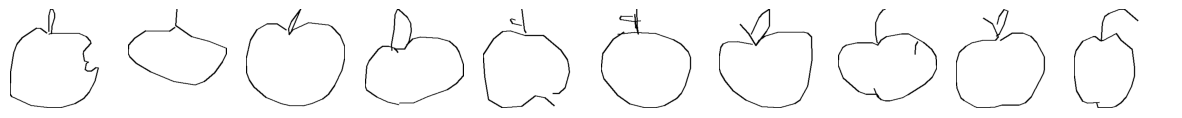

Class: candle


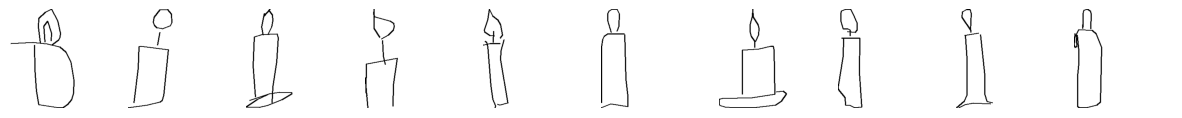

Class: moon


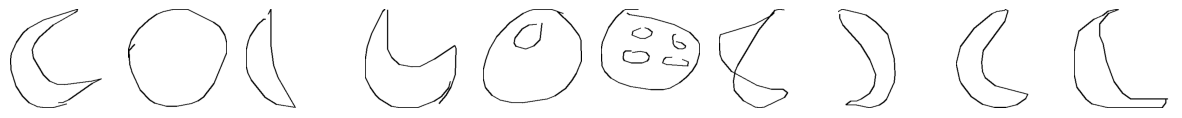

Class: spoon


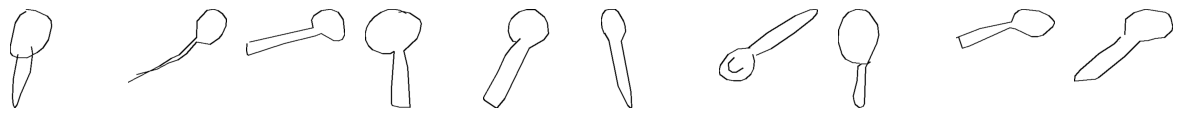

Class: square


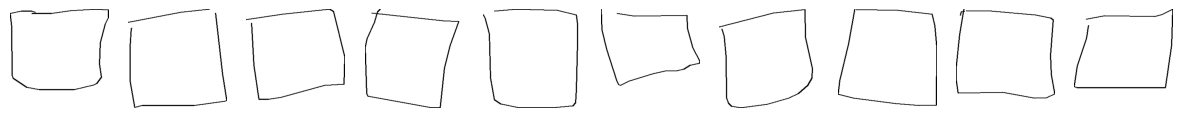

Class: star


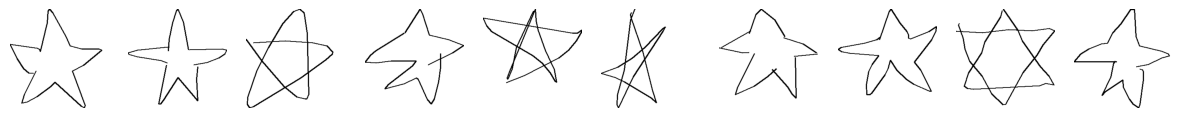

Class: traffic light


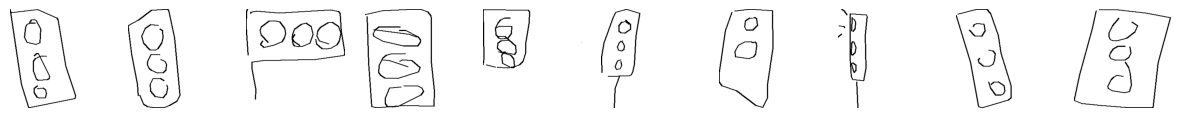

Class: circle


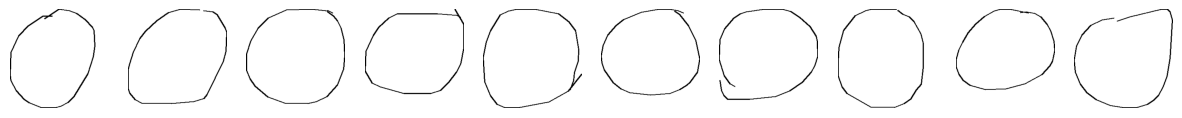

Class: triangle


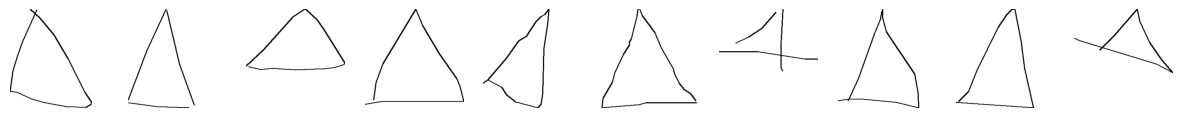

Class: cup


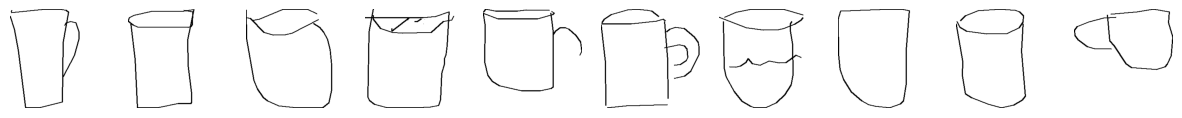

In [ ]:
# Converted stroke data to image
def strokes_to_image(strokes, size=(256, 256)):
    image = Image.new("RGB", size, "white")
    draw = ImageDraw.Draw(image)
    for stroke in strokes:
        for i in range(len(stroke[0]) - 1):
            draw.line(
                (stroke[0][i], stroke[1][i], stroke[0][i + 1], stroke[1][i + 1]),
                fill=0, width=3
            )
    return image

# To see k=10 images
def display_class_samples(df, class_name, k=5):
    subset = df[df['label'] == class_name]['drawing'].head(k)
    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    for i, drawing in enumerate(subset):
        img = strokes_to_image(drawing)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis("off")
    plt.show()

# Step 1: Display first few images per class
k=10
unique_classes = df['label'].unique()
for class_name in unique_classes:
    print(f"Class: {class_name}")
    display_class_samples(df, class_name, k)

In [ ]:
df.head()

,label,drawing
0,apple,"[[[95, 79, 68, 31, 17, 9, 1, 0, 4, 54, 103, 13..."
1,apple,"[[[121, 107, 45, 17, 1, 0, 4, 21, 58, 118, 173..."
2,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1..."
3,apple,"[[[85, 76, 61, 45, 34, 10, 4, 0, 4, 30, 58, 87..."
4,apple,"[[[184, 160, 135, 100, 50, 14, 4, 0, 27, 50, 7..."


In [ ]:
drawing = df['drawing'][2]  # First drawing
label = df['label'][2]  # Corresponding label

# Prepare x and y coordinates
x, y = [], []
for stroke in drawing:  # Iterate through each stroke
    x.extend(stroke[0])  # X-coordinates of stroke
    y.extend(stroke[1])  # Y-coordinates of stroke
    print(len(stroke[0]))
    x.append(None)  # Separate strokes
    y.append(None)

# Create frames for animation
frames = []
for i in range(1, len(x)):
    frames.append(go.Frame(
        data=[go.Scatter(
            x=x[:i+1],
            y=y[:i+1],
            mode='lines+markers',
            line=dict(color='black', width=2),
            marker=dict(size=1, color='black')
        )],
        name=f"frame_{i}"
    ))

# Create figure with animation controls
fig = go.Figure(
    data=[go.Scatter(x=[], y=[], mode='lines+markers')],
    layout=go.Layout(
        title=f"Animated Drawing: {label.title()}",
        xaxis=dict(range=[0, 300], autorange=False, title='X Coordinate'),
        yaxis=dict(range=[250, 0], autorange=False, title='Y Coordinate'),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(
                label="Play",
                method="animate",
                args=[None, {
                    'frame': {'duration': 100, 'redraw': True},
                    'fromcurrent': True,
                    'transition': {'duration': 0}
                }]
            )]
        )]
    )
)

fig.frames = frames

# Show figure
fig.show()

30


### Data Preprocessing

In [ ]:
import pandas as pd

# Function to augment selected samples
def augment_selected_samples(df, selected_good_samples, block_size, max_records_per_file):
    num_copies = max_records_per_file // block_size

    def replicate_selected_samples(s, label):
        if label in selected_good_samples:
            selected_indices = selected_good_samples[label]
            selected_indices = [i for i in selected_indices if i < len(s)]
            selected_drawings = s.iloc[selected_indices]

            if selected_drawings.empty:
                return s

            augmented_drawings = []
            for drawing in selected_drawings:
                augmented_drawings.extend([drawing] * num_copies)


            augmented_drawings = (augmented_drawings * ((len(s) // len(augmented_drawings)) + 1))[:len(s)]
            return pd.Series(augmented_drawings, index=s.index)

        return s.copy()

    # Apply transformation
    df['drawing'] = df.groupby('label', group_keys=False)['drawing'].apply(lambda s: replicate_selected_samples(s, s.name))
    return df


selected_good_samples = {
    'square': [1,2,15,17],
    'candle': [4, 8,11,19],
    'traffic light': [0,1,11,18],
    'apple': [2,5,14,24],
    'moon': [2,8,11,15],
    'spoon': [0,3,11,20,27],
    'star':[4,5,14,26],
    'cup':[31,35,38,39],
    'triangle':[1,8,10,18],
    'circle':[2,7,10,18]


}

block_size = 500
df = augment_selected_samples(df, selected_good_samples, block_size, max_records_per_file)



[Δx, Δy, pen_down, pen_up, pen_end]

In [ ]:
def process_drawing(drawing):
    seq = []
    prev_x, prev_y = 0, 0
    for stroke in drawing:
        xs, ys = stroke[0], stroke[1]
        for i in range(len(xs)):
            if i == 0:
                dx = xs[i] - prev_x
                dy = ys[i] - prev_y
            else:
                dx = xs[i] - xs[i - 1]
                dy = ys[i] - ys[i - 1]
            # mark as pen-down (token = [dx, dy, pen_down, pen_up, pen_end])
            token = [dx, dy, 1, 0, 0]
            # If it's the last point of the stroke, mark pen_up
            if i == len(xs) - 1:
                token = [dx, dy, 0, 1, 0]
            seq.append(token)
        # Set the last point of the stroke as the new starting point
        prev_x, prev_y = xs[-1], ys[-1]
    # Mark the very last token with end-of-drawing flag (set last element to 1)
    seq[-1][-1] = 1
    return np.array(seq, dtype=np.float32)

In [ ]:
df["processed_sequence"] = df["drawing"].apply(process_drawing)

In [ ]:
df.head()

,label,drawing,processed_sequence
0,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
1,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
2,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
3,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
4,apple,"[[[135, 83, 47, 34, 16, 6, 0, 1, 6, 31, 58, 78...","[[135.0, 60.0, 1.0, 0.0, 0.0], [-52.0, 1.0, 1...."


In [ ]:
import os
import pickle

def save_dataset(df, model_saver_path, filename="processed_data.pkl"):

    os.makedirs(model_saver_path, exist_ok=True)

    filepath = os.path.join(model_saver_path, filename)
    with open(filepath, "wb") as f:
        pickle.dump(df, f)

    print(f"Dataset saved to {filepath}")

# Save the dataset
save_dataset(df, model_saver_path)


Dataset saved to /content/drive/MyDrive/College-Work/output/processed_data.pkl


In [ ]:
def load_dataset(model_saver_path,filename="processed_data.pkl"):
    """Loads the DataFrame from a pickle file in the base directory."""
    filepath = os.path.join(model_saver_path, filename)  # Construct the full path
    with open(filepath, "rb") as f:
        df = pickle.load(f)
    print(f"Dataset loaded from {filepath}")
    return df

# Load the dataset
loaded_df = load_dataset(model_saver_path)

Dataset loaded from /content/drive/MyDrive/College-Work/output/processed_data.pkl


In [ ]:
loaded_df.head()

,label,drawing,processed_sequence
0,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
1,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
2,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
3,apple,"[[[104, 80, 54, 28, 11, 0, 1, 8, 20, 51, 90, 1...","[[104.0, 54.0, 1.0, 0.0, 0.0], [-24.0, -16.0, ..."
4,apple,"[[[135, 83, 47, 34, 16, 6, 0, 1, 6, 31, 58, 78...","[[135.0, 60.0, 1.0, 0.0, 0.0], [-52.0, 1.0, 1...."


In [ ]:
all_dx_dy = np.concatenate([np.array(seq)[:, :2] for seq in loaded_df["processed_sequence"].values])  # Only take dx, dy

# Standardize `dx` and `dy`
scaler = StandardScaler()
scaled_dx_dy = scaler.fit_transform(all_dx_dy)

split_points = np.cumsum([len(seq) for seq in loaded_df["processed_sequence"]])[:-1]
scaled_dx_dy_split = np.split(scaled_dx_dy, split_points)

def update_sequence(original, scaled):
    return np.hstack([scaled, np.array(original)[:, 2:]])

loaded_df["processed_sequence"] = [update_sequence(orig, scaled) for orig, scaled in zip(loaded_df["processed_sequence"], scaled_dx_dy_split)]



In [ ]:
loaded_df['processed_sequence'][3].shape

(30, 5)

In [ ]:
def save_standardized_data(df,model_saver_path, filename="standard_processed_data.pkl"):
    """Saves the standardized DataFrame as a pickle file in the base directory."""
    filepath = os.path.join(model_saver_path, filename)
    df.to_pickle(filepath)
    print(f"Standardized dataset saved to {filepath}")

# Save the standardized dataset
save_standardized_data(loaded_df,model_saver_path)

Standardized dataset saved to /content/drive/MyDrive/College-Work/output/standard_processed_data.pkl


In [ ]:
def save_scaler(scaler,model_saver_path, filename="scaler.pkl"):
    """Saves the scaler object as a pickle file in the base directory."""
    filepath = os.path.join(model_saver_path, filename)
    joblib.dump(scaler, filepath)
    print(f"Scaler saved to {filepath}")

# Save the scaler
save_scaler(scaler,model_saver_path)


Scaler saved to /content/drive/MyDrive/College-Work/output/scaler.pkl


In [ ]:
def load_standardized_data(model_saver_path,filename="standard_processed_data.pkl"):
    filepath = os.path.join(model_saver_path, filename)

    # Check if the file exists before loading
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    df = pd.read_pickle(filepath)
    print(f"Standardized dataset loaded from {filepath}")
    return df

df = load_standardized_data(model_saver_path)

Standardized dataset loaded from /content/drive/MyDrive/College-Work/output/standard_processed_data.pkl


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

def pad_sequences(sequences):
    padded_sequences = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)
    return padded_sequences


padded_sequences_result = pad_sequences(df['processed_sequence'])


df['processed_sequence'] = [padded_sequences_result[i] for i in range(padded_sequences_result.shape[0])]

### Class label mapping and dataset splitting

In [ ]:
num_classes = len(df['label'].unique())

# Create a mapping from labels to indices
label_to_idx = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_to_idx)


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['label_idx'])  # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,shuffle=True)  # Split temp into 15% val and 15% test


print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Train set size: 13382
Validation set size: 2868
Test set size: 2868


In [ ]:
val_df.head()

,label,drawing,processed_sequence,label_idx
6467,spoon,"[[[17, 27, 41, 64, 76, 87, 87, 85, 74, 59, 37,...","[[tensor(0.3305), tensor(0.3026), tensor(1.), ...",3
15830,triangle,"[[[98, 48, 0], [0, 108, 235]], [[100, 133, 171...","[[tensor(2.3536), tensor(-0.0725), tensor(1.),...",8
4249,moon,"[[[126, 105, 92, 46, 11, 0, 9, 13, 39, 68, 99,...","[[tensor(3.0529), tensor(-0.0063), tensor(1.),...",2
5862,spoon,"[[[41, 26, 13, 0, 0, 6, 18, 43, 70, 85, 99, 10...","[[tensor(0.9299), tensor(0.0599), tensor(1.), ...",3
9420,square,"[[[0, 160, 227, 225, 237, 250, 255, 248, 223, ...","[[tensor(-0.0941), tensor(0.2364), tensor(1.),...",4


In [ ]:
class SketchDataset(Dataset):
    def __init__(self, df):
        self.df = df
        if 'label_idx' not in self.df.columns:
            num_classes = len(self.df['label'].unique())
            label_to_idx = {label: idx for idx, label in enumerate(self.df['label'].unique())}
            self.df['label_idx'] = self.df['label'].map(label_to_idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        stroke = self.df['processed_sequence'].iloc[idx]
        label = self.df['label_idx'].iloc[idx]
        return stroke, label


train_dataset = SketchDataset(train_df)
val_dataset = SketchDataset(val_df)
test_dataset = SketchDataset(test_df)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: (
    pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True),
    torch.tensor([item[1] for item in batch])
))

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: (
    pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True),
    torch.tensor([item[1] for item in batch])
))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: (
    pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True),
    torch.tensor([item[1] for item in batch])
))



### Model: LSTM with attention


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size, dropout=0.1):
        super(Attention, self).__init__()
        self.scale = hidden_size ** 0.5  # Scaled Dot-Product Attention
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.shape
        hidden = hidden[-1].unsqueeze(1).expand(-1, seq_len, -1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) / self.scale
        attention_weights = F.softmax(self.v(energy).squeeze(2), dim=1)

        attention_weights = self.dropout(attention_weights + 1e-6)

        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        return context_vector, attention_weights


class ConditionalSketchRNN(nn.Module):
    def __init__(self, num_classes, class_emb_dim, stroke_input_dim, hidden_size, num_layers, dropout=0.1):
        super(ConditionalSketchRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.stroke_input_dim = stroke_input_dim

        self.learnable_init_state = nn.Parameter(torch.randn(num_layers, 1, hidden_size))
        self.layer_norm = nn.LayerNorm(hidden_size)

        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)
        self.encoder_lstm = nn.LSTM(class_emb_dim + stroke_input_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.attention = Attention(hidden_size, dropout=dropout)
        self.decoder_lstm = nn.LSTM(class_emb_dim + hidden_size + stroke_input_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc_out = nn.Linear(hidden_size, stroke_input_dim)

    def encode(self, stroke_seq, class_labels):

        batch_size, seq_len, _ = stroke_seq.shape
        class_emb = self.class_embedding(class_labels)

        h0 = self.layer_norm(self.learnable_init_state.expand(-1, batch_size, -1).contiguous())
        c0 = torch.zeros_like(h0)

        class_emb_expanded = class_emb.unsqueeze(1).expand(-1, seq_len, -1)
        lstm_input = torch.cat([stroke_seq, class_emb_expanded], dim=-1)

        # Forward pass through encoder LSTM
        encoder_outputs, (hidden_state, cell_state) = self.encoder_lstm(lstm_input, (h0, c0))

        return encoder_outputs, hidden_state, cell_state, class_emb

    def decode(self, encoder_outputs, hidden, cell, class_emb, max_seq_len):
        batch_size = class_emb.shape[0]
        outputs = []

        input_step = torch.cat([class_emb, torch.zeros(batch_size, self.stroke_input_dim, device=class_emb.device)], dim=-1).unsqueeze(1)

        for _ in range(max_seq_len):

            context_vector, _ = self.attention(hidden, encoder_outputs)
            decoder_input = torch.cat([input_step, context_vector], dim=-1)

            # Forward pass through decoder LSTM
            lstm_out, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))
            output = self.fc_out(lstm_out)

            outputs.append(output)
            input_step = torch.cat([class_emb, output.squeeze(1)], dim=-1).unsqueeze(1)

        return torch.cat(outputs, dim=1)

    def forward(self, stroke_seq, class_labels):
        encoder_outputs, hidden, cell, class_emb = self.encode(stroke_seq, class_labels)
        outputs = self.decode(encoder_outputs, hidden, cell, class_emb, stroke_seq.shape[1])
        return outputs

    def generate(self, class_label, max_seq_len=50):
        self.eval()
        device = next(self.parameters()).device
        class_label = torch.tensor([class_label], dtype=torch.long, device=device)
        class_emb = self.class_embedding(class_label)

        # Stabilized Initial Hidden State with layer norm
        h0 = self.layer_norm(self.learnable_init_state.expand(-1, 1, -1).contiguous())
        c0 = torch.zeros_like(h0)

        encoder_outputs = h0.mean(dim=0, keepdim=True).repeat(1, max_seq_len, 1)

        generated_sequence = self.decode(encoder_outputs, h0, c0, class_emb, max_seq_len)
        return generated_sequence.squeeze(0)


In [ ]:
for batch_idx, (padded_seqs, batch_class_labels) in enumerate(val_loader):
    print(f"Batch {batch_idx}:")
    print("Padded sequences shape:", padded_seqs.shape)
    print("Class labels shape:", batch_class_labels.shape)
    break

Batch 0:
Padded sequences shape: torch.Size([64, 52, 5])
Class labels shape: torch.Size([64])


<ipython-input-143-dfe160684f1b>:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



### LossWithLearnableWeights

In [ ]:
import torch
import torch.nn as nn

class LossWithLearnableWeights(nn.Module):
    def __init__(self, initial_stroke_weight=0.5, initial_pen_weight=0.5, temperature=1, device=None):
        super().__init__()
        self.device = device

        # Initialize learnable logit weights
        self.logit_stroke_weight = nn.Parameter(
            torch.logit(torch.tensor(initial_stroke_weight + 1e-6, device=self.device))
        )
        self.logit_pen_weight = nn.Parameter(
            torch.logit(torch.tensor(initial_pen_weight + 1e-6, device=self.device))
        )

        self.temperature = temperature

    def get_weights(self):
        stroke_weight =torch.sigmoid(self.logit_stroke_weight / self.temperature)
        pen_weight = torch.sigmoid(self.logit_pen_weight / self.temperature)

        return stroke_weight, pen_weight

    def forward(self, pred_dxdy, true_dxdy, pred_pen, true_pen):
        pred_dxdy, true_dxdy = pred_dxdy.to(self.device), true_dxdy.to(self.device)
        pred_pen, true_pen = pred_pen.to(self.device), true_pen.to(self.device)


        if true_pen.dim() == 3 and true_pen.shape[-1] > 1:
            true_pen = torch.argmax(true_pen, dim=-1)

        if pred_pen.dim() != 3:
            raise ValueError(f"Expected pred_pen to have shape [batch, seq_len, num_classes], but got {pred_pen.shape}")

        if true_pen.dim() != 2:
            raise ValueError(f"Expected true_pen to have shape [batch, seq_len], but got {true_pen.shape}")

        # loss functions
        mse_loss = nn.MSELoss(reduction='mean')
        ce_loss = nn.CrossEntropyLoss(reduction='mean')

        stroke_loss = mse_loss(pred_dxdy, true_dxdy)
        pen_state_loss = ce_loss(pred_pen.permute(0, 2, 1), true_pen)

        # Compute dynamic weights
        stroke_weight, pen_weight = self.get_weights()

        # Compute final weighted loss
        # total_loss = stroke_weight * stroke_loss + pen_weight * pen_state_loss
        total_loss =   stroke_loss +   pen_state_loss
        return total_loss, stroke_loss, pen_state_loss


### Training loop

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, initial_stroke_weight, num_epochs=20, save_dir="saved_predictions", patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_function = LossWithLearnableWeights(initial_stroke_weight, device=device).to(device)
    optimizer.add_param_group({'params': loss_function.parameters()})
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)

    os.makedirs(save_dir, exist_ok=True)

    class_reference_dict = {}
    for stroke_seq, class_label in val_loader.dataset:
        class_label = class_label.item()
        if class_label not in class_reference_dict:
            class_reference_dict[class_label] = stroke_seq.clone().detach()

    train_loss_list = []
    val_loss_list = []
    best_val_loss = float("inf")
    epochs_since_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for stroke_seqs, class_labels in train_loader:
            stroke_seqs, class_labels = stroke_seqs.to(device), class_labels.to(device)
            optimizer.zero_grad()
            outputs = model(stroke_seqs, class_labels)
            pred_dxdy, pred_pen = outputs[:, :, :2], outputs[:, :, 2:]
            true_dxdy, true_pen = stroke_seqs[:, :, :2], stroke_seqs[:, :, 2:]
            loss, _, _ = loss_function(pred_dxdy, true_dxdy, pred_pen, true_pen)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        generated_strokes_dict = {}

        with torch.no_grad():
            for class_label, true_stroke_seq in class_reference_dict.items():
                class_label_tensor = torch.tensor([class_label], dtype=torch.long).to(device)
                seq_len, stroke_input_dim = true_stroke_seq.shape
                dummy_seq = torch.zeros(1, seq_len, stroke_input_dim).to(device)

                # Use forward pass with dummy input and class label for one sample
                generated_strokes = model(dummy_seq, torch.tensor([class_label], device=device))
                generated_strokes_dict[class_label] = generated_strokes

                true_stroke_seq = true_stroke_seq.to(device).unsqueeze(0)
                # Preserve batch dimension when slicing:
                min_seq_len = min(true_stroke_seq.shape[1], generated_strokes.shape[1])
                generated_strokes = generated_strokes[:, :min_seq_len, :]
                true_stroke_seq = true_stroke_seq[:, :min_seq_len, :]

                pred_dxdy, pred_pen = generated_strokes[:, :, :2], generated_strokes[:, :, 2:]
                true_dxdy, true_pen = true_stroke_seq[:, :, :2], true_stroke_seq[:, :, 2:]
                loss, stroke_weight, pen_weight = loss_function(pred_dxdy, true_dxdy, pred_pen, true_pen)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(class_reference_dict)
        val_loss_list.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f} , stroke_loss: {stroke_weight:.4f}, pen_loss : {pen_weight:.4f}")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            print(f"Validation loss did not improve for {epochs_since_improvement} epochs.")

        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

        save_path = os.path.join(save_dir, f"epoch_{epoch+1}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(generated_strokes_dict, f)
        print(f"Saved generated strokes: {save_path}")

    return train_loss_list, val_loss_list


### Training

In [ ]:
# Instantiate the model.
num_classes = len(df['label'].unique())

model = ConditionalSketchRNN(num_classes, class_emb_dim, stroke_input_dim, hidden_size, num_layers)

optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=.00001)
# optimizer = optim.RAdam(model.parameters(), lr=learning_rate,weight_decay=.00001)

In [ ]:
train_loss,val_loss = train_model(model,train_loader, val_loader, optimizer,initial_stroke_weight=initial_stroke_weight, num_epochs=epoch,patience=3)


<ipython-input-143-dfe160684f1b>:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1, Train Loss: 0.8899, Validation Loss: 0.5449 , stroke_loss: 0.1388, pen_loss : 0.2237
Saved generated strokes: saved_predictions/epoch_1.pkl
Epoch 2, Train Loss: 0.5799, Validation Loss: 0.4717 , stroke_loss: 0.0751, pen_loss : 0.1917
Saved generated strokes: saved_predictions/epoch_2.pkl
Epoch 3, Train Loss: 0.5085, Validation Loss: 0.4402 , stroke_loss: 0.0762, pen_loss : 0.1725
Saved generated strokes: saved_predictions/epoch_3.pkl
Epoch 4, Train Loss: 0.4629, Validation Loss: 0.4368 , stroke_loss: 0.0834, pen_loss : 0.1688
Saved generated strokes: saved_predictions/epoch_4.pkl
Epoch 5, Train Loss: 0.4182, Validation Loss: 0.4101 , stroke_loss: 0.0757, pen_loss : 0.1711
Saved generated strokes: saved_predictions/epoch_5.pkl
Epoch 6, Train Loss: 0.3704, Validation Loss: 0.3592 , stroke_loss: 0.0735, pen_loss : 0.1647
Saved generated strokes: saved_predictions/epoch_6.pkl
Epoch 7, Train Loss: 0.3186, Validation Loss: 0.3381 , stroke_loss: 0.0807, pen_loss : 0.1615
Saved genera

In [ ]:
def save_model(model,model_saver_path, filename="sketch_rnn_model.pth"):
    """Saves the PyTorch model state dictionary in the base directory."""
    filepath = os.path.join(model_saver_path, filename)  # Construct the full path
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

save_model(model,model_saver_path)





Model saved to /content/drive/MyDrive/College-Work/output/sketch_rnn_model.pth


### Plotting

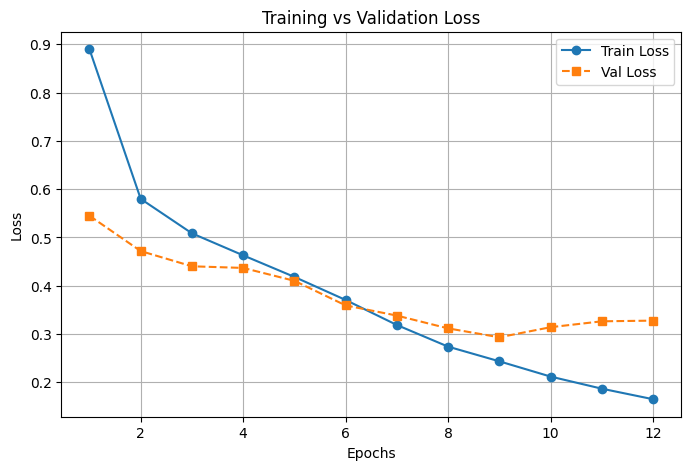

In [ ]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss", marker="o", linestyle="-")
    plt.plot(epochs, val_loss, label="Val Loss", marker="s", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(train_loss, val_loss)


In [ ]:
import os
import pickle
import torch
import matplotlib.pyplot as plt

def process_and_plot_strokes(scaler, save_dir="saved_predictions", output_dir="generated_images"):
    """
    Loads generated stroke data from .pkl files in `save_dir`, applies the inverse transform to dx,dy,
    converts differential strokes to absolute coordinates, and saves plotted images to `output_dir`.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Sort the pickle files to process epochs in ascending order
    pkl_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".pkl")])

    for pkl_file in pkl_files:
        epoch_num = pkl_file.split("_")[-1].split(".")[0]
        file_path = os.path.join(save_dir, pkl_file)

        with open(file_path, "rb") as f:
            generated_strokes_dict = pickle.load(f)

        # Process each class's generated strokes
        for class_label, generated_seq in generated_strokes_dict.items():
            dxdy_scaled = generated_seq[0, :, :2].cpu().numpy()


            dxdy_original = scaler.inverse_transform(dxdy_scaled)
            generated_seq[0, :, :2] = torch.tensor(dxdy_original, device=generated_seq.device)


            absolute_stroke = [[], []]
            current_x, current_y = 0, 0

            # Convert entire sequence (batch dim removed) to numpy for iteration
            gen_np = generated_seq[0].cpu().numpy()
            for token in gen_np:
                dx, dy = token[:2]
                current_x += dx
                current_y += dy
                absolute_stroke[0].append(current_x)
                absolute_stroke[1].append(current_y)


            plt.figure()
            plt.plot(absolute_stroke[0], absolute_stroke[1], marker='o')
            plt.title(f"Class {class_label} - Epoch {epoch_num}")
            plt.gca().invert_yaxis()
            plt.axis("equal")


            img_path = os.path.join(output_dir, f"class_{class_label}_epoch_{epoch_num}.png")
            plt.savefig(img_path)
            plt.close()
            print(f"Saved image: {img_path}")


In [ ]:
from PIL import Image
import os
import glob

def create_gifs(output_dir="generated_images", gif_dir="generated_gifs"):
    """
    Creates GIFs for each class by compiling the generated images across epochs.

    Args:
        output_dir (str): Directory where the generated images are stored.
        gif_dir (str): Directory where the GIFs will be saved.
    """
    os.makedirs(gif_dir, exist_ok=True)

    # Group images by class label
    class_files = {}
    for img_file in sorted(glob.glob(os.path.join(output_dir, "class_*.png"))):

        file_name = os.path.basename(img_file)
        parts = file_name.split("_")

        if len(parts) >= 3 and parts[0] == "class":
            class_label = parts[1]  # Extract the class label
            class_files.setdefault(class_label, []).append(img_file)

    # Generate a GIF for each class
    for class_label, img_files in class_files.items():
        frames = [Image.open(img) for img in img_files]

        if frames:
            gif_path = os.path.join(gif_dir, f"class_{class_label}.gif")
            frames[0].save(
                gif_path,
                format="GIF",
                append_images=frames[1:],
                save_all=True,
                duration=300,
                loop=0
            )
            print(f"Saved GIF: {gif_path}")


In [ ]:
process_and_plot_strokes(scaler)


Saved image: generated_images/class_3_epoch_1.png
Saved image: generated_images/class_8_epoch_1.png
Saved image: generated_images/class_2_epoch_1.png
Saved image: generated_images/class_4_epoch_1.png
Saved image: generated_images/class_5_epoch_1.png
Saved image: generated_images/class_7_epoch_1.png
Saved image: generated_images/class_6_epoch_1.png
Saved image: generated_images/class_0_epoch_1.png
Saved image: generated_images/class_9_epoch_1.png
Saved image: generated_images/class_1_epoch_1.png
Saved image: generated_images/class_3_epoch_10.png
Saved image: generated_images/class_8_epoch_10.png
Saved image: generated_images/class_2_epoch_10.png
Saved image: generated_images/class_4_epoch_10.png
Saved image: generated_images/class_5_epoch_10.png
Saved image: generated_images/class_7_epoch_10.png
Saved image: generated_images/class_6_epoch_10.png
Saved image: generated_images/class_0_epoch_10.png
Saved image: generated_images/class_9_epoch_10.png
Saved image: generated_images/class_1_epo

In [ ]:
create_gifs()


Saved GIF: generated_gifs/class_0.gif
Saved GIF: generated_gifs/class_1.gif
Saved GIF: generated_gifs/class_2.gif
Saved GIF: generated_gifs/class_3.gif
Saved GIF: generated_gifs/class_4.gif
Saved GIF: generated_gifs/class_5.gif
Saved GIF: generated_gifs/class_6.gif
Saved GIF: generated_gifs/class_7.gif
Saved GIF: generated_gifs/class_8.gif
Saved GIF: generated_gifs/class_9.gif


In [ ]:
def load_scaler(model_saver_path, filename="scaler.pkl"):
    """Loads the scaler object from a pickle file in the base directory."""
    filepath = os.path.join(model_saver_path, filename)
    scaler = joblib.load(filepath)
    print(f"Scaler loaded from {filepath}")
    return scaler

def load_model(num_classes, class_emb_dim, stroke_input_dim, hidden_size, num_layers, model_saver_path, filename="sketch_rnn_model.pth", device=None):
    filepath = os.path.join(model_saver_path, filename)

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    model = ConditionalSketchRNN(num_classes, class_emb_dim, stroke_input_dim, hidden_size, num_layers)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.load_state_dict(torch.load(filepath, map_location=device))
    print(f"Model loaded from {filepath} to {device}")
    return model

scaler = load_scaler(model_saver_path)


# num_classes=5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model(num_classes, class_emb_dim, stroke_input_dim, hidden_size, num_layers,model_saver_path,device=device)

Scaler loaded from /content/drive/MyDrive/College-Work/output/scaler.pkl
Model loaded from /content/drive/MyDrive/College-Work/output/sketch_rnn_model.pth to cpu


<ipython-input-143-dfe160684f1b>:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_spoon.png


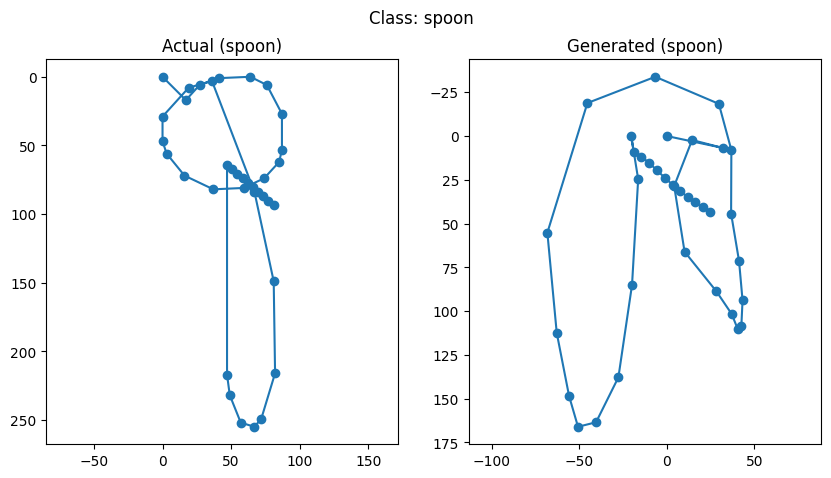

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_triangle.png


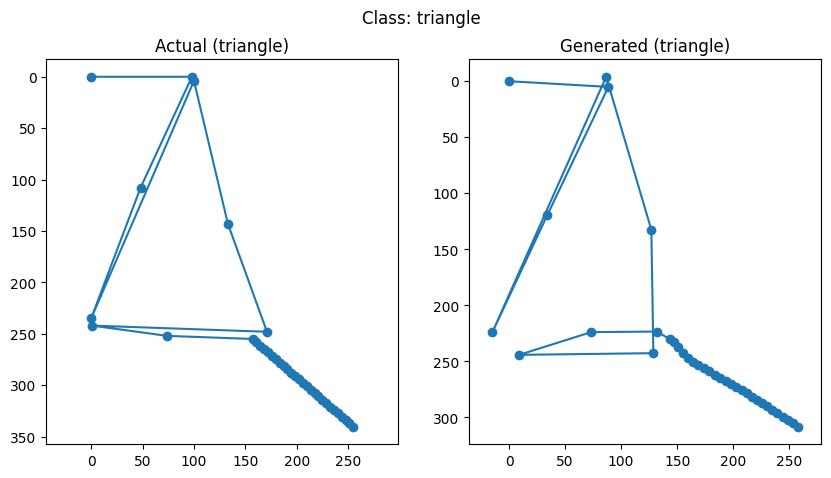

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_apple.png


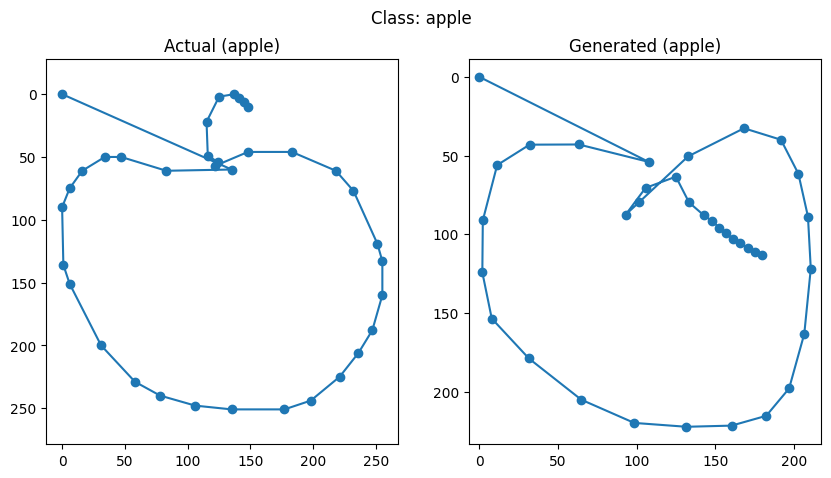

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_candle.png


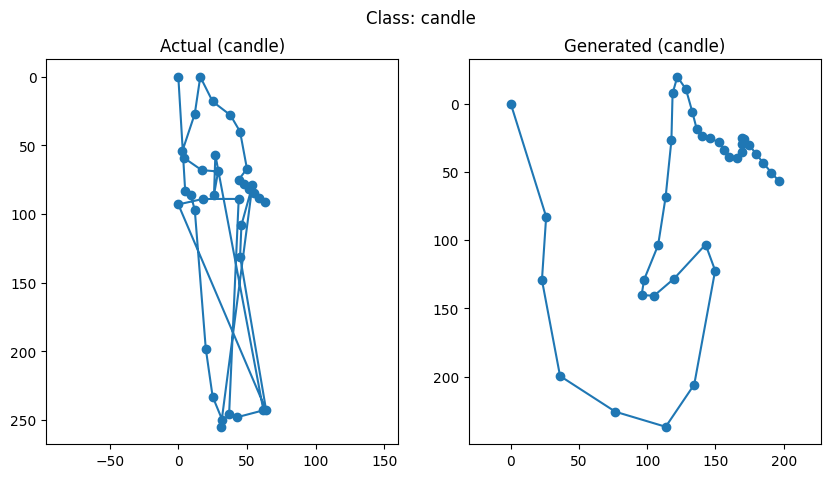

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_star.png


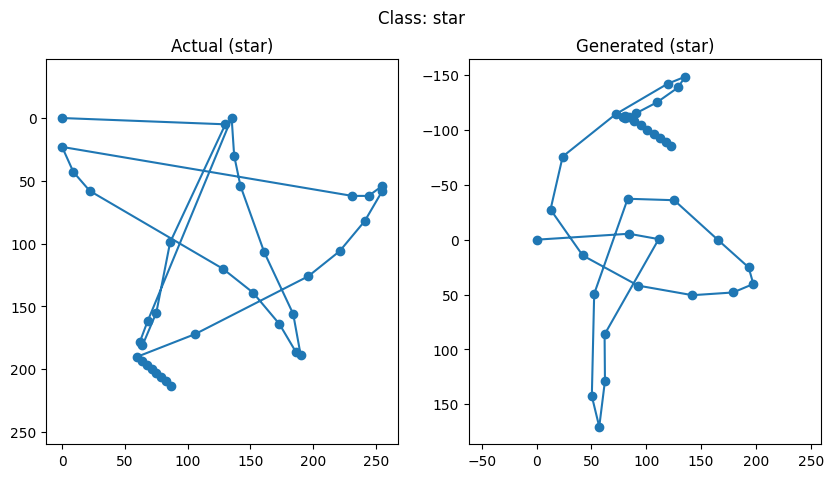

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_moon.png


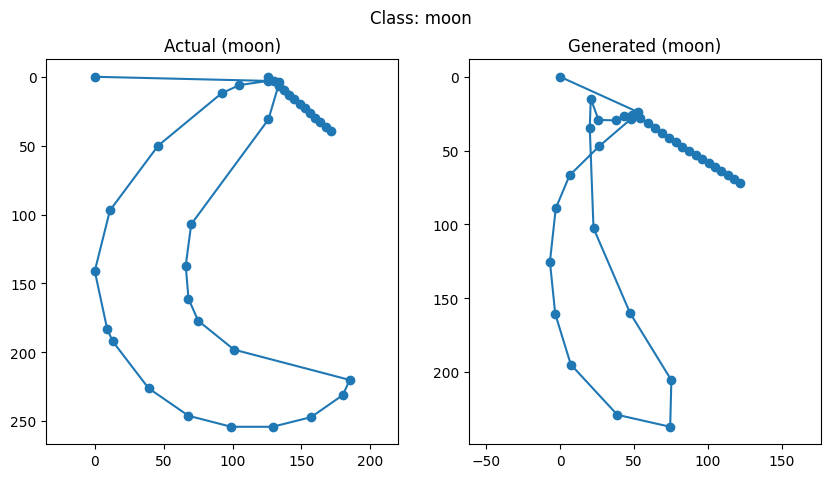

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_square.png


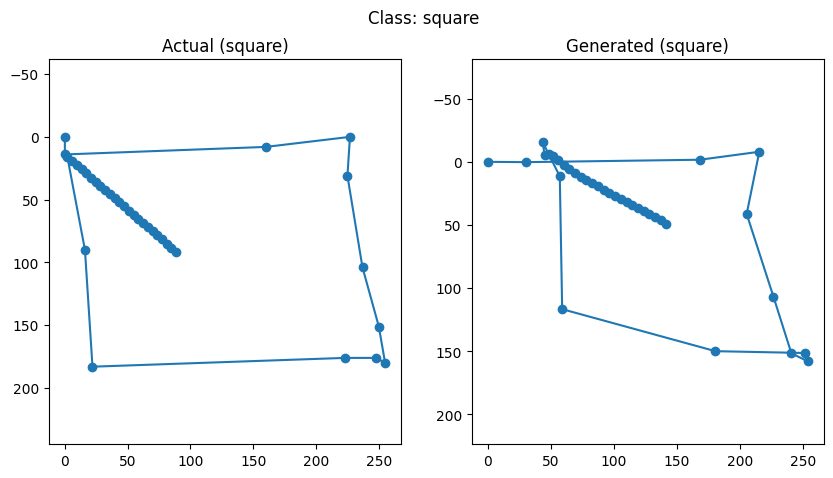

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_circle.png


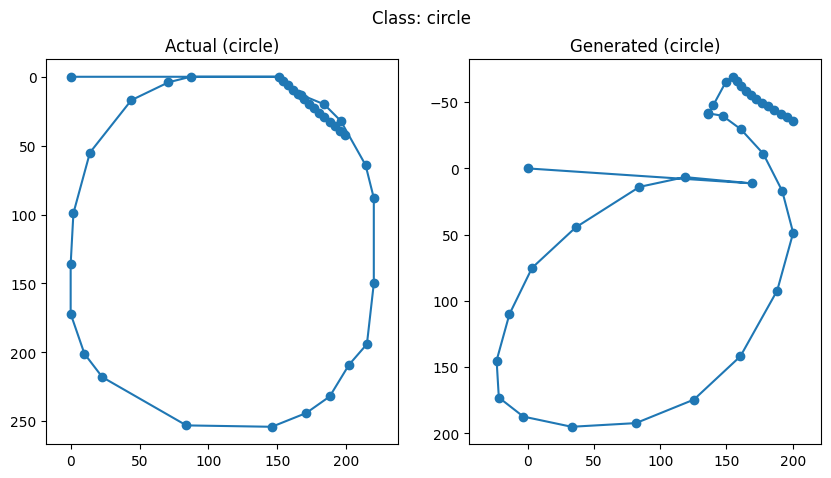

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_cup.png


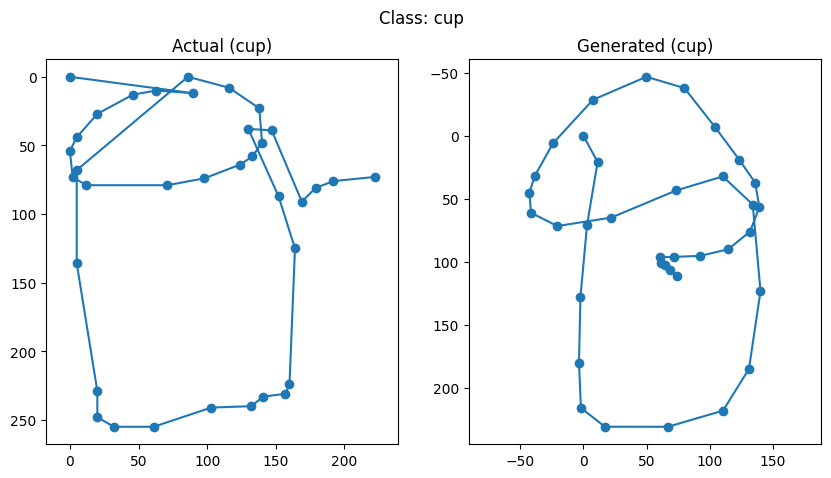

Saved comparison image: /content/drive/MyDrive/College-Work/images/comparison_traffic light.png


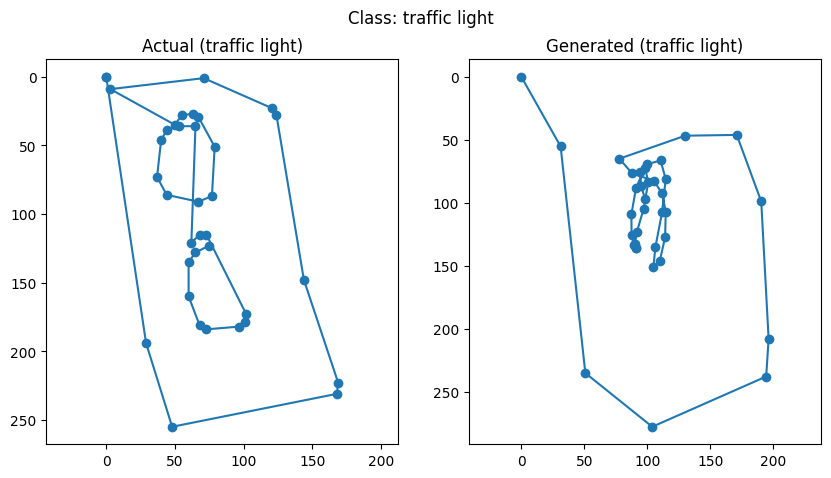

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

def plot_predictions(model, image_saver_path, test_loader, scaler, label_to_idx, idx_to_label, dummy_seq_len=35):
    os.makedirs(image_saver_path, exist_ok=True)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    seen_classes = set()

    with torch.no_grad():
        for i, (padded_seqs, batch_class_labels) in enumerate(test_loader):
            for j in range(len(batch_class_labels)):
                class_idx = batch_class_labels[j].item()
                class_label = idx_to_label[class_idx]

                if class_label in seen_classes:
                    continue

                seen_classes.add(class_label)

                # **Actual Drawing** (Limit sequence length)
                actual_seq = padded_seqs[j, :dummy_seq_len, :2].cpu().numpy()
                actual_seq = scaler.inverse_transform(actual_seq)

                act_x, act_y = [0], [0]
                for dx, dy in actual_seq:
                    act_x.append(act_x[-1] + dx)
                    act_y.append(act_y[-1] + dy)

                # **Generated Drawing** (Using dummy sequence of zeros)
                zero_input = torch.zeros(1, dummy_seq_len, model.fc_out.out_features).to(device)
                class_embedding = batch_class_labels[j:j+1].to(device)
                generated_seq = model(zero_input, class_embedding)[0, :dummy_seq_len, :2].cpu().numpy()
                generated_seq = scaler.inverse_transform(generated_seq)

                gen_x, gen_y = [0], [0]
                for dx, dy in generated_seq:
                    gen_x.append(gen_x[-1] + dx)
                    gen_y.append(gen_y[-1] + dy)

                fig, axs = plt.subplots(1, 2, figsize=(10, 5))

                axs[0].plot(act_x, act_y, marker='o')
                axs[0].set_title(f"Actual ({class_label})")
                axs[0].invert_yaxis()
                axs[0].axis("equal")

                axs[1].plot(gen_x, gen_y, marker='o')
                axs[1].set_title(f"Generated ({class_label})")
                axs[1].invert_yaxis()
                axs[1].axis("equal")

                plt.suptitle(f"Class: {class_label}")

                img_filename = os.path.join(image_saver_path, f"comparison_{class_label}.png")
                plt.savefig(img_filename)
                print(f"Saved comparison image: {img_filename}")

                plt.show()

                if len(seen_classes) == len(label_to_idx):
                    return

# Example Call:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
plot_predictions(model, image_saver_path, test_loader, scaler, label_to_idx, idx_to_label, dummy_seq_len=35)


In [ ]:
def animate_generated_drawing(model, test_loader, scaler, idx_to_label, dummy_seq_len=35):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    stroke_input_dim = model.fc_out.out_features
    class_drawings = {}

    with torch.no_grad():
        for _, batch_class_labels in test_loader:
            for label in batch_class_labels:
                class_idx = label.item()
                class_name = idx_to_label[class_idx]

                if class_name in class_drawings:
                    continue

                # **Generate strokes using zero input and class embedding**
                dummy_seq = torch.zeros(1, dummy_seq_len, stroke_input_dim).to(device)
                class_embedding = torch.tensor([class_idx]).to(device)
                outputs = model(dummy_seq, class_embedding)

                # **Extract and inverse-transform dx, dy**
                predicted_dx_dy = outputs[0, :-1, :2].cpu().numpy()
                absolute_coords = scaler.inverse_transform(predicted_dx_dy)


                x, y, current_x, current_y = [], [], 0, 0
                full_x, full_y = [], []
                for dx, dy in absolute_coords:
                    current_x += dx
                    current_y += dy
                    x.append(current_x)
                    y.append(current_y)
                    x.append(None)
                    y.append(None)

                    full_x.extend([current_x, None])
                    full_y.extend([current_y, None])

                class_drawings[class_name] = (full_x, full_y)


                if len(class_drawings) == len(idx_to_label):
                    break


    dropdown_buttons = []
    frames = []

    for class_name, (x, y) in class_drawings.items():
        frame_names = []

        for j in range(1, len(x), 2):
            frame_name = f"frame_{class_name}_{j}"
            frame_names.append(frame_name)

            frames.append(
                go.Frame(
                    data=[
                        go.Scatter(  # Line trace
                            x=x[:j+1:2], y=y[:j+1:2],
                            mode='lines',
                            line=dict(color='blue', width=2)
                        ),
                        go.Scatter(  # Dot trace
                            x=x[:j+1:2], y=y[:j+1:2],
                            mode='markers',
                            marker=dict(size=5, color='red', symbol='circle')
                        )
                    ],
                    name=frame_name
                )
            )


        dropdown_buttons.append(dict(
            label=class_name,
            method="animate",
            args=[frame_names, {
                "frame": {"duration": 100, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 0}
            }]
        ))

    fig = go.Figure(
        data=[
            go.Scatter(x=[], y=[], mode='lines'),
            go.Scatter(x=[], y=[], mode='markers')
        ],
        layout=go.Layout(
            title="Select a Class & Play Animation",
            xaxis=dict(range=[0, 300], autorange=False, title='X Coordinate'),
            yaxis=dict(range=[250, 0], autorange=False, title='Y Coordinate'),
            updatemenus=[
                dict(
                    buttons=dropdown_buttons,
                    direction="down",
                    showactive=True
                ),
                dict(  # Play Button
                    type="buttons",
                    buttons=[
                        dict(
                            label="Play",
                            method="animate",
                            args=[None, {
                                "frame": {"duration": 100, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }]
                        )
                    ]
                )
            ]
        ),
        frames=frames
    )

    fig.show()


idx_to_label = {idx: label for label, idx in label_to_idx.items()}
animate_generated_drawing(model, test_loader, scaler, idx_to_label)

<ipython-input-143-dfe160684f1b>:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-143-dfe160684f1b>:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

